### TODO
- Now we can take the special cases we added to info_grupos back to frac_vars.xlsx since we have them in cols to avoid.
- The HelperFunctions can raise Errors or warning that help us identify null values, mismatching vars and things like that.

In [2]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
import pickle
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
from info_grupos import empirical_vars_to_avoid, frac_vars_special_cases_list
from genera_muestra import GenerateLHS
from utils import HelperFunctions

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf
import sisepuede as si

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
target_country = 'croatia'
id_experimento = 1


In [5]:
FILE_PATH = os.getcwd()
build_path = lambda PATH : os.path.abspath(os.path.join(*PATH))

DATA_PATH = build_path([FILE_PATH, "..", "data"])
OUTPUT_PATH = build_path([FILE_PATH, "..", "output"])

SSP_OUTPUT_PATH = build_path([OUTPUT_PATH, "ssp"])

REAL_DATA_FILE_PATH = build_path([DATA_PATH, "real_data.csv"]) 

SALIDAS_EXPERIMENTOS_PATH = build_path([OUTPUT_PATH, "experiments"]) 

INPUTS_ESTRESADOS_PATH = build_path([SALIDAS_EXPERIMENTOS_PATH, "sim_inputs"])
OUTPUTS_ESTRESADOS_PATH = build_path([SALIDAS_EXPERIMENTOS_PATH, "sim_outputs"])
helper_functions = HelperFunctions()

helper_functions.ensure_directory_exists(INPUTS_ESTRESADOS_PATH)
helper_functions.ensure_directory_exists(OUTPUTS_ESTRESADOS_PATH)

Directory already exists: /home/tony-ubuntu/decision_sciences/lhs_ssp_sampling/output/experiments/sim_inputs
Directory already exists: /home/tony-ubuntu/decision_sciences/lhs_ssp_sampling/output/experiments/sim_outputs


In [6]:
### Cargamos datos de ejemplo de costa rica

examples = SISEPUEDEExamples()
cr = examples("input_data_frame")

In [7]:
df_input = pd.read_csv(REAL_DATA_FILE_PATH)
df_input.head()

,region,iso_code3,period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,...,yf_agrc_fruits_tonne_ha,yf_agrc_herbs_and_other_perennial_crops_tonne_ha,yf_agrc_nuts_tonne_ha,yf_agrc_other_annual_tonne_ha,yf_agrc_other_woody_perennial_tonne_ha,yf_agrc_pulses_tonne_ha,yf_agrc_rice_tonne_ha,yf_agrc_sugar_cane_tonne_ha,yf_agrc_tubers_tonne_ha,yf_agrc_vegetables_and_vines_tonne_ha
0,croatia,HRV,0,8807000,70,2923,31.751466,6468,315,508,...,5.546667,28.8742,0.602367,1.930675,0.5205,2.638183,0,0,35.76480,21.067738
1,croatia,HRV,1,8807000,70,2923,31.751466,6468,315,508,...,5.555383,29.6558,0.479900,2.304050,0.7342,3.256933,0,0,47.57660,20.412554
2,croatia,HRV,2,8807000,70,2923,31.751466,6468,315,508,...,4.304906,30.0390,0.360400,2.075950,0.8615,3.199083,0,0,41.09780,22.329531
3,croatia,HRV,3,8807000,70,2923,31.751466,6468,315,508,...,6.272229,30.0390,0.160300,2.662133,0.9852,3.266680,0,0,37.42445,21.505800
4,croatia,HRV,4,8807000,70,2923,31.751466,6468,315,508,...,5.878853,30.0390,0.196325,2.543567,0.9045,4.068040,0,0,39.81490,21.874247


In [8]:
df_input = df_input.rename(columns={'period':'time_period'})
df_input = helper_functions.add_missing_cols(cr, df_input.copy())
df_input = df_input.drop(columns='iso_code3')

In [9]:
df_input.head()

,region,time_period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,croatia,0,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,croatia,1,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,croatia,2,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,croatia,3,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,croatia,4,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [10]:
# Double checking that our df is in the correct shape MAKE SURE THIS IS OK THEY HAVE TO BE EQUAL!
helper_functions.compare_dfs(cr, df_input)

Columns in df1 but not in df2: set()
Columns in df2 but not in df1: set()
Columns shared in both df1 and df2: {'frac_waso_biogas_yard', 'exports_lvst_goats', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_coke', 'ef_fgtv_production_flaring_tonne_ch4_per_m3_fuel_oil', 'occrate_trns_passenger_per_vehicle_human_powered', 'vol_ippu_recycled_textiles_m3_ww_per_tonne_production', 'frac_inen_energy_rubber_and_leather_solid_biomass', 'regressionb_agrc_above_ground_residue_rice_kg_per_ha', 'frac_trns_fuelmix_road_heavy_regional_electricity', 'frac_inen_energy_lime_and_carbonite_kerosene', 'nemomod_entc_emissions_activity_ratio_scalar_pp_coal_co2', 'nemomod_entc_reserve_margin_tag_technology_st_batteries', 'mcf_waso_average_landfilled', 'ef_soil_c_liming_dolomite', 'frac_inen_energy_chemicals_furnace_gas', 'elasticity_lvst_cattle_nondairy_demand_to_gdppc', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_nuclear', 'cost_enfu_fuel_biofuels_usd_per_m3', 'qty_ippu_glass_tonne_cod_per_m3_ww',

In [11]:
# Checking if there are any columns with null values in it
helper_functions.get_cols_with_nans(df_input)

[]


[]

In [12]:
columns_all_999 = df_input.columns[(df_input == -999).any()].tolist()
columns_all_999

['frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biogas',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biomass',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal_ccs',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas_ccs',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_geothermal',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_hydropower',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_nuclear',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_ocean',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_oil',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_solar',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_waste_incineration',
 'frac_entc_max_elec_production_increase_to_satisfy_msp_pp_wind',
 'limit_gnrl_annual_emissions_mt_ch

In [13]:
# Avoid land use stuff and some frac special cases
pij_cols = [col for col in df_input.columns if col.startswith('pij')]
cols_to_avoid = pij_cols + frac_vars_special_cases_list + columns_all_999 + empirical_vars_to_avoid
campos_estresar = helper_functions.get_indicators_col_names(df_input, cols_with_issue=cols_to_avoid)

In [14]:
# Defines upper bound to pass to GenerateLHS
u_bound = 2

# Defines number of sample vectors that GenerateLHS will create
n_vectors = 100
sampling_file_path = os.path.join('sampling_files', f'sample_scaled_{n_vectors}_{u_bound}.pickle') 

# Generates sampling matrix
if not os.path.exists(sampling_file_path):
    # Generates sampling matrix if it does not exist
    generate_sample = GenerateLHS(n_vectors, n_var=len(campos_estresar), u_bound=u_bound)
    generate_sample.generate_sample()

# Load the sampling matrix
with open(sampling_file_path, 'rb') as handle:
    sample_scaled = pickle.load(handle)

In [15]:
lhs_sampling_array = sample_scaled[id_experimento]

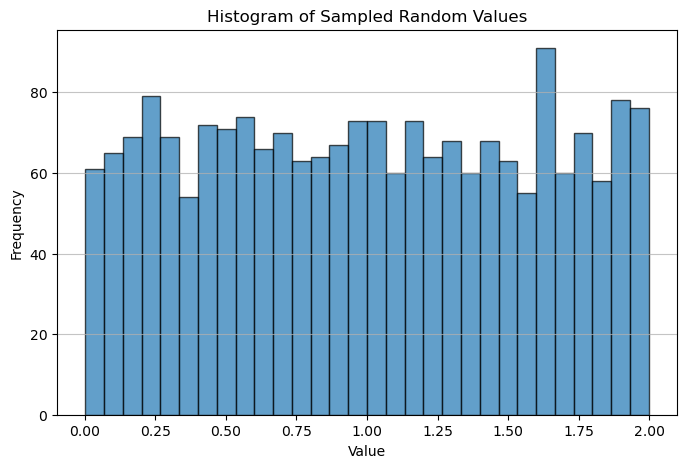

In [16]:
# Plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(sample_scaled[1], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Sampled Random Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [17]:
df_input['ef_lndu_conv_croplands_to_forests_secondary_gg_co2_ha']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
Name: ef_lndu_conv_croplands_to_forests_secondary_gg_co2_ha, dtype: int64

In [20]:
df_estresado = df_input.copy()
df_estresado[campos_estresar]  = (df_input[campos_estresar]*lhs_sampling_array).to_numpy()

In [25]:
df_estresado['frac_agrc_bevs_and_spices_cl1_temperate']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
Name: frac_agrc_bevs_and_spices_cl1_temperate, dtype: float64

In [22]:
# Load new groups that need normalization
df_frac_vars = pd.read_excel('frac_vars.xlsx', sheet_name='frac_vars_no_special_cases')
df_frac_vars.head()

,frac_var_name,frac_var_name_prefix
0,frac_agrc_bevs_and_spices_cl1_temperate,frac_agrc_bevs_and_spices_cl1
1,frac_agrc_bevs_and_spices_cl1_tropical,frac_agrc_bevs_and_spices_cl1
2,frac_agrc_bevs_and_spices_cl2_dry,frac_agrc_bevs_and_spices_cl2
3,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_bevs_and_spices_cl2
4,frac_agrc_cereals_cl1_temperate,frac_agrc_cereals_cl1


In [23]:
need_norm_prefix = df_frac_vars.frac_var_name_prefix.unique()

In [24]:
### Normaliza grupo de variables para que sumen 1 en conjunto

for grupo in need_norm_prefix:
    vars_grupo = [i for i in df_estresado.columns if grupo in i]
    
    # Skip normalization for columns in cols_to_avoid
    if any(col in cols_to_avoid for col in vars_grupo):
        continue

    # Apply conditional log transformation
    df_estresado[vars_grupo] = df_estresado[vars_grupo].applymap(lambda y: -np.log(y) if y != 0 else 0)
    
    # Check if the sum is zero before normalizing
    sum_values = df_estresado[vars_grupo].sum(axis=1)
    df_estresado[vars_grupo] = df_estresado[vars_grupo].div(sum_values, axis=0).fillna(0)


# This is also an special case
ce_problematic = ['frac_waso_biogas_food',
                  'frac_waso_biogas_sludge',
                  'frac_waso_biogas_yard',
                  'frac_waso_compost_food',
                  'frac_waso_compost_methane_flared',
                  'frac_waso_compost_sludge',
                  'frac_waso_compost_yard']

# Apply conditional log transformation
df_estresado[ce_problematic] = df_estresado[ce_problematic].applymap(lambda y: -np.log(y) if y != 0 else 0)
# Check if the sum is zero before normalizing
sum_values = df_estresado[ce_problematic].sum(axis=1)
df_estresado[ce_problematic] = df_estresado[ce_problematic].div(sum_values, axis=0).fillna(0)



####################

In [34]:
# # Assuming df_estresado is defined and contains columns
# vars_grupo = [i for i in df_estresado.columns if i.startswith('frac_')]

# df_frac_vars = pd.DataFrame(vars_grupo, columns=['frac_var_name'])
# df_frac_vars.sort_values(by='frac_var_name', inplace=True)

# # Extract prefix by removing the last '_{word}' segment
# df_frac_vars['frac_var_name_prefix'] = df_frac_vars['frac_var_name'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# df_frac_vars.to_csv('frac_vars.csv', index=False)

###########

In [35]:
# Checking if there are any columns with null values in it
columns_with_na = helper_functions.get_cols_with_nans(df_estresado)
if columns_with_na:
    df_estresado[columns_with_na] = df_estresado[columns_with_na].fillna(0)

helper_functions.get_cols_with_nans(df_estresado)

[]
[]


[]

In [36]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_estresado,
)

##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# set an ouput path and instantiate

trf.instantiate_default_strategy_directory(
        transformers,
        SSP_OUTPUT_PATH,
    )

# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
        SSP_OUTPUT_PATH,
        transformers = transformers,
    )

strategies = trf.Strategies(
        transformations,
        export_path = "transformations",
        prebuild = True,
    )

In [37]:


# call the example
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
        df_trajgroup = df_vargroups,
        include_simplex_group_as_trajgroup = True,
        strategies = [0, 1000],
    )



0

In [38]:
import sisepuede as si
ssp = si.SISEPUEDE(
        "calibrated",
        initialize_as_dummy = False, # no connection to Julia is initialized if set to True
        regions = [target_country],
        db_type = "csv",
        strategies = strategies,
        try_exogenous_xl_types_in_variable_specification = True,
    )

2024-11-19 18:41:06,800 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-19 18:41:06,802 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-19 18:41:06,803 - INFO - 	Setting export engine to 'csv'.
2024-11-19 18:41:06,804 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-19 18:41:06,805 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-11-19 18:41:06,806 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2024-11-19 18:41:06,808 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2024-11-19 18:41:06,809 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2024-11-19 18:41:06,810 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2024-11-19 18:41:06,812 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   2647.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-19 18:42:07,083 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-19 18:42:07,116 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-19 18:42:07,127 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11

In [39]:
# Checks if the land use reallocation factor is set to 0.0
helper_functions.check_land_use_factor(ssp_object=ssp, target_country=target_country)

In [40]:
# Create parameters dict for the model to run
dict_run = {
        ssp.key_future: [0],
        ssp.key_design: [0],
        ssp.key_strategy: [
            0,
            1000,
        ],
    }


In [41]:
# we'll save inputs since we're doing a small set of runs
ssp.project_scenarios(
        dict_run,
        save_inputs = True,
    )

2024-11-19 18:42:11,523 - INFO - 
***	STARTING REGION croatia	***



2024-11-19 18:42:15,370 - INFO - Trying run primary_id = 0 in region croatia
2024-11-19 18:42:15,371 - INFO - Running AFOLU model
2024-11-19 18:42:15,551 - INFO - AFOLU model run successfully completed
2024-11-19 18:42:15,552 - INFO - Running CircularEconomy model
2024-11-19 18:42:15,607 - INFO - CircularEconomy model run successfully completed
2024-11-19 18:42:15,608 - INFO - Running IPPU model
2024-11-19 18:42:15,688 - INFO - IPPU model run successfully completed
2024-11-19 18:42:15,690 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-19 18:42:15,712 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-19 18:42:15,823 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-19 18:42:15,824 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
2024-11-19 18:42:15,860 - INFO - 	Path to temporary

2024-19-Nov 18:42:16.661 Opened SQLite database at /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-19-Nov 18:42:17.005 Added NEMO structure to SQLite database at /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-19-Nov 18:42:34.600 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-19 18:43:45,560 - INFO - NemoMod run failed with result INFEASIBLE. Populating missing data with value 0.0.
2024-11-19 18:43:45,566 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2024-11-19 18:43:45,616 - INFO - EnergyProduction model run successfully completed
2024-11-19 18:43:45,617 - INFO - Running Energy (Fugitive Emissions)
2024-11-19 18:43:45,664 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2024-11-19 18:43:45,665 - INFO - Appending Socioeconomic outputs
2024-11-19 18:43:45,674 - INFO - Socioeconomic outputs successfully appended.
2024-11-19 18:43:45,679 - INFO - Model run for primary_id = 0 successfully completed in 90.31 seconds (n_tries = 1).
2024-11-19 18:43:45,694 -

2024-19-Nov 18:43:45.501 Solver did not find a solution for model. No results will be saved to database.
2024-19-Nov 18:43:45.526 Finished modeling scenario.


2024-11-19 18:43:45,906 - INFO - AFOLU model run successfully completed
2024-11-19 18:43:45,906 - INFO - Running CircularEconomy model
2024-11-19 18:43:45,973 - INFO - CircularEconomy model run successfully completed
2024-11-19 18:43:45,974 - INFO - Running IPPU model
2024-11-19 18:43:46,075 - INFO - IPPU model run successfully completed
2024-11-19 18:43:46,076 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-19 18:43:46,098 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-19 18:43:46,217 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-19 18:43:46,218 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-19-Nov 18:43:48.278 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-19 18:44:45,751 - INFO - NemoMod run failed with result INFEASIBLE. Populating missing data with value 0.0.
2024-11-19 18:44:45,756 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2024-11-19 18:44:45,791 - INFO - EnergyProduction model run successfully completed
2024-11-19 18:44:45,792 - INFO - Running Energy (Fugitive Emissions)
2024-11-19 18:44:45,840 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2024-11-19 18:44:45,842 - INFO - Appending Socioeconomic outputs
2024-11-19 18:44:45,862 - INFO - Socioeconomic outputs successfully appended.
2024-11-19 18:44:45,869 - INFO - Model run for primary_id = 1001 successfully completed in 60.17 seconds (n_tries = 1).
2024-11-19 18:44:45,90

2024-19-Nov 18:44:45.734 Solver did not find a solution for model. No results will be saved to database.
2024-19-Nov 18:44:45.749 Finished modeling scenario.


2024-11-19 18:44:45,994 - INFO - Table MODEL_OUTPUT successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-19T18;41;06.229677/sisepuede_run_2024-11-19T18;41;06.229677_output_database/MODEL_OUTPUT.csv.
2024-11-19 18:44:46,000 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-19T18;41;06.229677/sisepuede_run_2024-11-19T18;41;06.229677_output_database/ATTRIBUTE_PRIMARY.csv.
2024-11-19 18:44:46,184 - INFO - Table MODEL_INPUT successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-19T18;41;06.229677/sisepuede_run_2024-11-19T18;41;06.229677_output_database/MODEL_INPUT.csv.


{'croatia': [0, 1001]}

In [52]:
INPUTS_ESTRESADOS_FILE_PATH = build_path([INPUTS_ESTRESADOS_PATH, f"sim_input_{id_experimento}.csv"])
OUTPUTS_ESTRESADOS_FILE_PATH = build_path([OUTPUTS_ESTRESADOS_PATH, f"sim_output_{id_experimento}.csv"])


df_out = ssp.read_output(None)
df_out.to_csv(OUTPUTS_ESTRESADOS_FILE_PATH, index=False)
df_estresado[campos_estresar].to_csv(INPUTS_ESTRESADOS_FILE_PATH, index=False)

helper_functions.print_elapsed_time(start_time)

------------------------ EXECUTION TIME: 399.9020211696625 seconds ------------------------


In [ ]:
df_out.to_csv('croatia_dummy_output.csv', index=False)

: 